In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report

import itertools
%matplotlib inline
sns.set()

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# read in train, test, sample submission data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [4]:
train.columns

Index(['customer_id', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed'],
      dtype='object')

In [5]:
train["source"] = 1
test["source"] =0

data = pd.concat([train, test]).reset_index(drop=True)
print(data.shape)
print(train.shape)
print(test.shape)

(41188, 23)
(28831, 23)
(12357, 22)


In [6]:
data.isna().sum()

customer_id           0
age                   0
job                   0
marital               0
education             0
default               0
housing               0
loan                  0
contact               0
month                 0
day_of_week           0
duration              0
campaign              0
pdays                 0
previous              0
poutcome              0
emp_var_rate          0
cons_price_idx        0
cons_conf_idx         0
euribor3m             0
nr_employed           0
subscribed        12357
source                0
dtype: int64

In [7]:
#data.profile_report()

In [8]:
data.columns

Index(['customer_id', 'age', 'job', 'marital', 'education', 'default',
       'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
       'subscribed', 'source'],
      dtype='object')

In [10]:
data.drop(["customer_id", 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'], axis=1, inplace=True)

In [11]:
#checking for unique values in the categorcal columns, to examine their entries
cat_cols = data.columns[data.dtypes == object]
for col in cat_cols:
    print(col.upper(), "column has", data[col].nunique(), "unique values:\n", data[col].value_counts())

JOB column has 12 unique values:
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64
MARITAL column has 4 unique values:
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64
EDUCATION column has 8 unique values:
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64
DEFAULT column has 3 unique values:
 no         32588
unknown     8597
yes            3
Name: default, dtype: int64
HOUSING column has 3 unique values:
 yes        21576
no         18622
unknown      990
Name: housing, dtype: in

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    data[col] = le.fit_transform(data[col])
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,subscribed,source
0,31,0,1,6,0,0,0,0,2,1,1.283333,3,999,1,0,0.0,1
1,31,9,2,6,0,0,0,1,6,0,0.200000,4,999,0,1,0.0,1
2,47,1,1,1,1,2,0,1,6,2,4.616667,2,999,0,1,0.0,1
3,36,7,1,6,0,0,0,0,6,2,1.166667,1,999,1,0,0.0,1
4,34,0,2,3,0,0,0,0,6,0,19.683333,9,999,0,1,0.0,1


In [13]:

train_df = data.loc[data["source"] ==1]
test_df = data.loc[data["source"] ==0]

In [14]:


test_df.drop(["source", "subscribed"], axis=1, inplace=True)
train_df.drop(["source"], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
print(data.shape)
print(train_df.shape)
print(test_df.shape)

(41188, 17)
(28831, 16)
(12357, 15)


In [16]:
y = train.subscribed
X = train_df.drop(["subscribed"], axis=1)

In [17]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 1234)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20181, 15), (20181,), (8650, 15), (8650,))

In [18]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(f1_score(pred, y_test))

0.4231311706629055


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [19]:
from sklearn.tree import DecisionTreeClassifier
decisiontreemodel = DecisionTreeClassifier()

decisiontreemodel.fit(X_train, y_train)
pred = decisiontreemodel.predict(X_test)
print(f1_score(pred, y_test))

0.44920877998979064


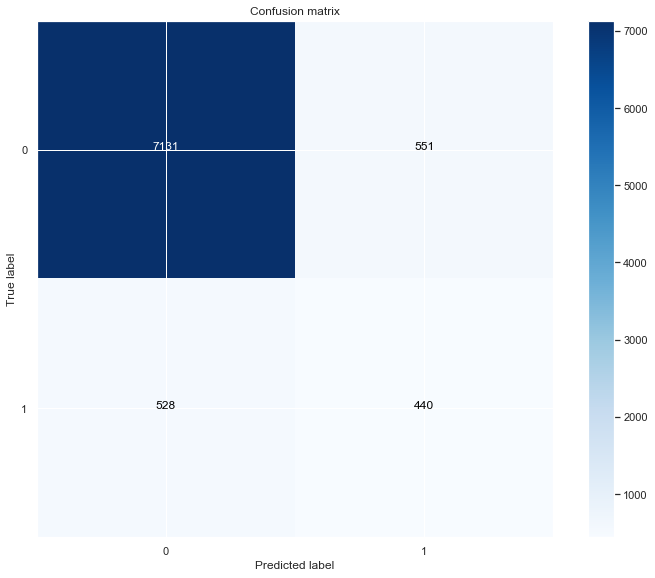

In [20]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [33]:
train_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,subscribed
0,31,0,1,6,0,0,0,0,2,1,1.283333,3,999,1,0,0.0
1,31,9,2,6,0,0,0,1,6,0,0.200000,4,999,0,1,0.0
2,47,1,1,1,1,2,0,1,6,2,4.616667,2,999,0,1,0.0
3,36,7,1,6,0,0,0,0,6,2,1.166667,1,999,1,0,0.0
4,34,0,2,3,0,0,0,0,6,0,19.683333,9,999,0,1,0.0


In [ ]:
predictions = decisiontreemodel.predict(test_df)

In [ ]:
predictions

In [ ]:
sub.head()

In [ ]:
preds = pd.DataFrame({"customer_id": sub["customer_id"],"subscribed":predictions})

In [ ]:
preds.to_csv("predis.csv", index=False)

from here, move on to kaggle and submit the predis.csv file 

# Standardize Values and Retry Model

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [28]:
sc = StandardScaler()

In [29]:
sc.fit(X_train)
X_train_std =sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [30]:
svc = SVC(kernel='linear', C=10.0, random_state = 100)
svc.fit(X_train, y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=100, shrinking=True, tol=0.001,
    verbose=False)

In [31]:
y1_pred = svc.predict(X_test)

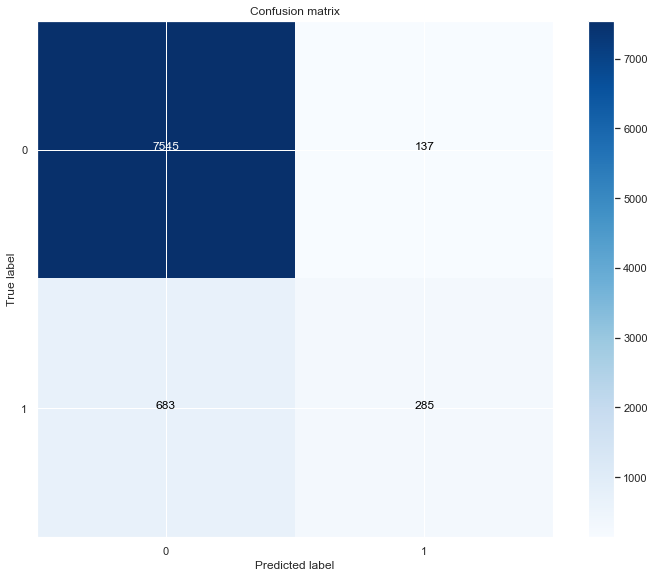

In [32]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,y1_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

# SVC

In [21]:
from sklearn.svm import SVC

In [40]:
svc = SVC(kernel='linear', random_state = 1234)
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1234, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
y0_pred = svc.predict(X_test)

In [42]:
y0_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

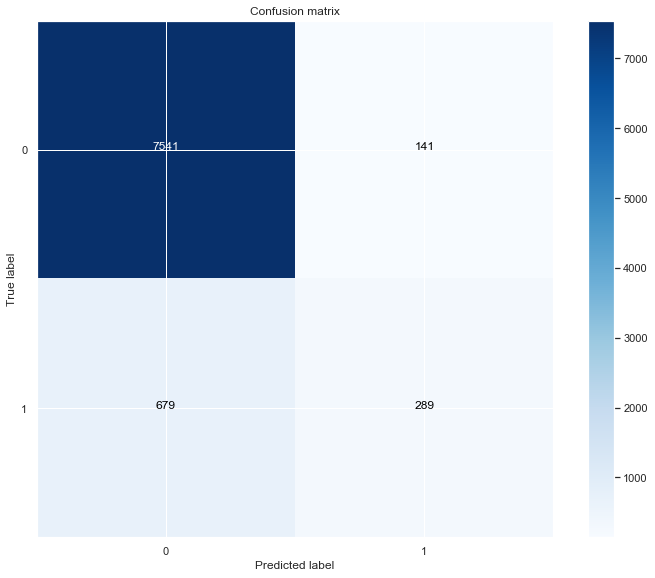

In [43]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,y0_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

In [44]:
print(f1_score(y0_pred, y_test))

0.413447782546495


# Rand Forest

In [34]:
model2 = RandomForestClassifier()

In [35]:
model2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
rand_pred = model2.predict(X_test)

In [37]:
rand_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [38]:
print(f1_score(rand_pred, y_test))

0.48307291666666663


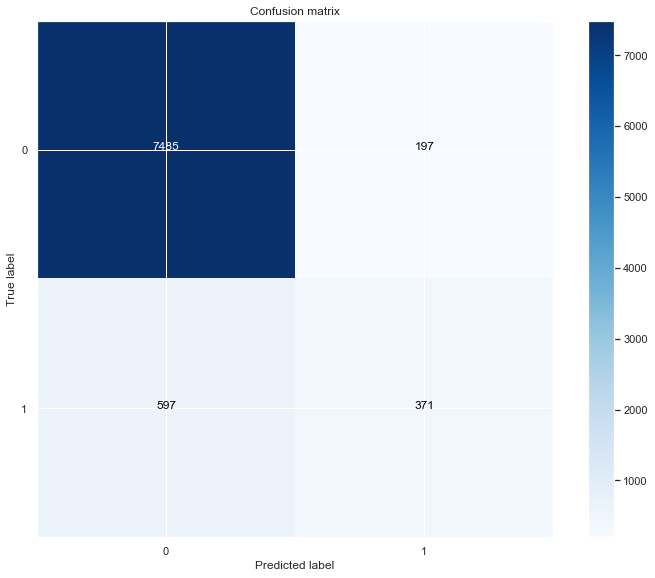

In [39]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test,rand_pred)
np.set_printoptions(precision=2)


class_names = [0,1]

plt.figure(figsize=(10,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

# Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

In [46]:
gnb = GaussianNB()

In [47]:
gnb.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [48]:
y00_pred = gnb.predict(X_test)

In [49]:
y00_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [50]:
print(f1_score(y00_pred, y_test))

0.4221525600835946


**Export Submission Dataset**

In [ ]:
test_df.head()

In [ ]:
predictions = model2.predict(test_df)

In [ ]:
sns.countplot(predictions)

In [ ]:
test_df.tail()

In [ ]:
test['customer_id']

In [ ]:
sub.head()

In [ ]:
predictions.shape

In [ ]:
sub.shape

In [ ]:
preds = pd.DataFrame({"customer_id": sub["customer_id"],"subscribed": predictions})

In [ ]:
preds.head()

In [ ]:
preds.to_csv("aisub2.csv", index=False)